In [1]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from time import time
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [3]:
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.spatial.distance import euclidean

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
dataset_root = Path('../../Dataset/ingested')

In [6]:
#df_file = sorted(list((dataset_root).glob('features*.csv')))[ 0 ]
#df_file = sorted(list((dataset_root).glob('fsfel_spectral_features*.csv')))[ 0 ]
#df_file = sorted(list((dataset_root).glob('fsfel_temporal_features*.csv')))[ 0 ]
#df_file = sorted(list((dataset_root).glob('fsfel_statistical_features*.csv')))[ 0 ]
df_files = sorted(list((dataset_root).glob('fsfel_all_features*.csv')))

In [7]:
df_files

[PosixPath('../../Dataset/ingested/fsfel_all_features_0.csv'),
 PosixPath('../../Dataset/ingested/fsfel_all_features_1.csv'),
 PosixPath('../../Dataset/ingested/fsfel_all_features_2.csv')]

In [8]:
df_features = pd.concat([ pd.read_csv( df_file, index_col = 'sample_name' ) for df_file in df_files ])


In [9]:
df_features

,Absolute energy,Area under the curve,Autocorrelation,Centroid,ECDF Percentile Count_0,ECDF Percentile Count_1,ECDF Percentile_0,ECDF Percentile_1,ECDF_0,ECDF_1,...,Wavelet variance_0,Wavelet variance_1,Wavelet variance_2,Wavelet variance_3,Wavelet variance_4,Wavelet variance_5,Wavelet variance_6,Wavelet variance_7,Wavelet variance_8,Zero crossing rate
sample_name,,,,,,,,,,,,,,,,,,,,,
MAC000002-2012-10,143.028305,2.776200,143.028305,10.898703,299.0,1196.0,0.000,0.307,0.000669,0.001338,...,0.020536,0.041642,0.076114,0.118772,0.159664,0.187189,0.199345,0.203901,0.209303,5.0
MAC000002-2012-11,142.307686,3.448940,142.307686,6.714764,299.0,1196.0,0.103,0.289,0.000669,0.001338,...,0.030100,0.042896,0.057508,0.077917,0.095408,0.108746,0.120687,0.133895,0.149320,9.0
MAC000002-2012-12,151.318359,3.555400,151.318359,7.013707,299.0,1196.0,0.104,0.293,0.000669,0.001338,...,0.031424,0.050123,0.071109,0.094537,0.114834,0.131182,0.146861,0.164570,0.184545,6.0
MAC000002-2013-01,154.403864,3.598440,154.403864,7.811695,299.0,1196.0,0.109,0.278,0.000669,0.001338,...,0.031152,0.054426,0.069617,0.089890,0.116362,0.145060,0.173281,0.200144,0.225378,4.0
MAC000002-2013-02,238.548989,3.817305,238.548989,8.363299,299.0,1196.0,0.088,0.288,0.000669,0.001338,...,0.038880,0.085373,0.162035,0.242712,0.310418,0.366311,0.415521,0.460266,0.502049,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MAC000362-2013-12,19.297520,1.278995,19.297520,7.820106,298.0,1194.0,0.031,0.135,0.000670,0.001340,...,0.003881,0.006265,0.009709,0.013659,0.017521,0.020537,0.022489,0.023903,0.025350,2.0
MAC000362-2014-01,17.224751,1.229200,17.224751,7.416443,298.0,1194.0,0.031,0.126,0.000670,0.001340,...,0.003449,0.005210,0.007747,0.010369,0.013109,0.015600,0.017666,0.019536,0.021523,2.0
MAC000362-2014-02,15.567642,1.010265,15.567642,5.914056,298.0,1194.0,0.024,0.110,0.000670,0.001340,...,0.003868,0.005505,0.009020,0.012693,0.015399,0.016804,0.017027,0.016694,0.016467,3.0


# TSNE dimensionality reduction visualization

In [10]:
def show_2d(reduced_data, args):
    plt.figure( figsize = (6,6) )
    xy = reduced_data
    plt.plot(xy[:, 0], xy[:, 1], "o")
    plt.title(f"TSNE({args}")
    plt.show()

In [11]:
tsne_args = {'n_components':2, 
         'learning_rate':'auto',
         'perplexity':30,
         'n_iter': 1000
        }

dbscan_args = {'eps' : 5 , 
               'min_samples' : 10, 
               'metric' : 'euclidean', 
               'metric_params' : None, 
               'algorithm' : 'auto', 
               'leaf_size' : 30, 
               'p' : None
        }

In [13]:
def visualize_clusters_dbscan_2models( X, db1, db2, t1, t2  ):
    
    def plt_db_clusters( ax, db, title ):
        core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
        core_samples_mask[db.core_sample_indices_] = True
        labels = db.labels_

        n_clusters = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)
        n_noise = list(db.labels_).count(-1)
    
        ax.set_title(f'{title} - {n_clusters=} {n_noise=}')

        # Black removed and is used for noise instead.
        unique_labels = set(labels)
        colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

        for k, col in zip(unique_labels, colors):
            if k == -1:
                # Black used for noise.
                col = [0, 0, 0, 1]
            class_member_mask = labels == k

            xy = X[class_member_mask & core_samples_mask]
            ax.plot(
                xy[:, 0],
                xy[:, 1],
                "o",
                color=tuple(col),
                markersize=8,
                alpha = 0.2
            )
            xy = X[class_member_mask & ~core_samples_mask]
            ax.plot(
                xy[:, 0],
                xy[:, 1],
                "o",
                color=tuple(col),
                markersize=4,
                alpha = 0.2
            )
            

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    plt_db_clusters( axs[0], db1, t1 )
    plt_db_clusters( axs[1], db2, t2 )
    
    plt.show()

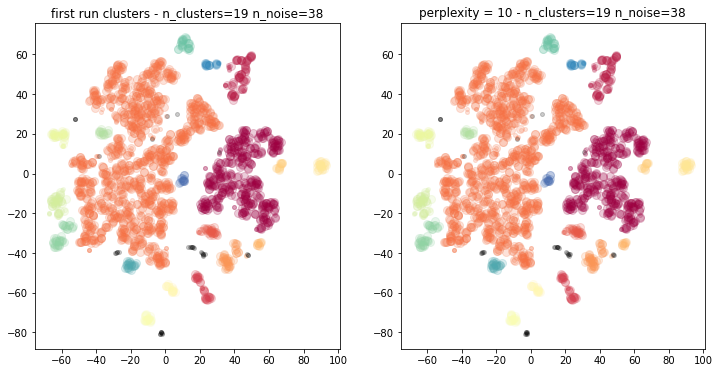

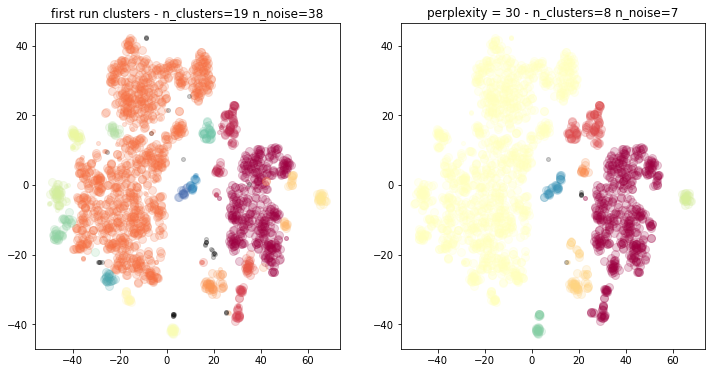

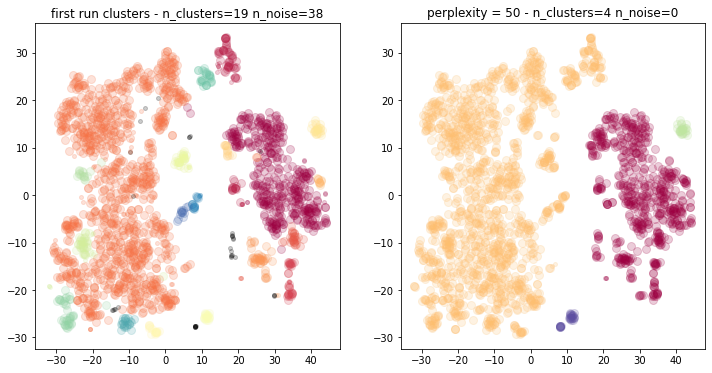

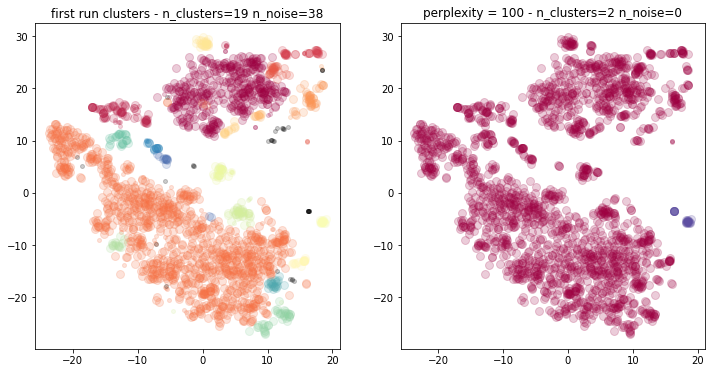

In [14]:
db1 = None
for p in [10, 30, 50, 100]:
    tsne_args['perplexity'] = p
    tsne = TSNE(**tsne_args)
    np.random.seed(101)
    reduced_data = make_pipeline(StandardScaler(), tsne).fit_transform( df_features.values )
    if db1 is None :
        np.random.seed(101)
        db1 = DBSCAN( **dbscan_args ).fit(reduced_data)
        title1 = f'perplexity = {p}'
        db2 = db1    
    else :
        np.random.seed(101)
        db2 = DBSCAN( **dbscan_args ).fit(reduced_data)
    
    visualize_clusters_dbscan_2models( reduced_data, db1, db2, 'first run clusters', f'perplexity = {p}' )
